In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
import matplotlib.pyplot as plt
from typing import Optional

In [ ]:
!huggingface-cli login --token <your huggingface generated token here>

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
The token `number1` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `number1`


In [ ]:
from transformers import AutoTokenizer
from transformers import PaliGemmaForConditionalGeneration, PaliGemmaConfig, SiglipVisionConfig, GemmaConfig

tokenizer = AutoTokenizer.from_pretrained("google/paligemma2-3b-pt-224")
vision_config = SiglipVisionConfig(
    image_size=224,
    patch_size=14,
    num_hidden_layers=27,
    num_attention_heads=16,
    hidden_size=1152,
    intermediate_size=4096,
    vocab_size=257152,
    vision_use_head=False
)

# Initialize Gemma text configuration
text_config = GemmaConfig(
    hidden_size=2048,
    num_hidden_layers=18,
    intermediate_size=16384,
    num_attention_heads=8,
    num_key_value_heads=1,
    is_encoder_decoder=False,
    vocab_size=257152
)

paliConfig = PaliGemmaConfig(
    vision_config=vision_config.to_dict(),
    text_config=text_config.to_dict(),
    projection_dim=2048,
    hidden_size=2048
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

In [ ]:
@dataclass
class Configs:
  patchSize:int = 16
  embeddingChannels:int = 32
  batchSize: int = 2
  layerNormEps: int = 1e-5
  intermediateEmbedding :int = 32 * 4
  numLayers: int = 6
  numHeads: int = 4
  dropoutRate:float = 0.5
  training: bool = True
  imageDim:int = 28
  device:str = 'cuda'

class SiglipVisionEmbedding(nn.Module):

  def __init__(self, config: Configs, layerNormEps: int = 1e-5, attentionDropout: int = 0.1, numImageTokens: int = 0):
    super().__init__()

    self.patchConv = nn.Conv2d(3, config.embeddingChannels,  config.patchSize, config.patchSize) #assuming rgb image
    self.numPositions = torch.arange((config.imageDim // config.patchSize)** 2).to(device = config.device) #after flattening, this is how many tokens to attach positional embedding to
    self.positionEmbeddings = nn.Embedding(self.numPositions.shape[0], config.embeddingChannels) #just embedding the index of patch
  def forward(self, x):
    x = self.patchConv(x)
    x = torch.flatten(x, 2) #B, C, H * W
    x = x.transpose(1, 2) #B, H * W, C (because we want a sequence of embeddings listed in order)
    x = self.positionEmbeddings(self.numPositions) + x

    return x

class SiglipFeedForward(nn.Module):
  def __init__(self, config: Configs):
    super().__init__()
    self.fc1 = nn.Linear(config.embeddingChannels, config.intermediateEmbedding)
    # self.activation = F.gelu(approximate = 'tanh')
    self.fc2 = nn.Linear(config.intermediateEmbedding, config.embeddingChannels)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(F.gelu(x, approximate = 'tanh'))
    return x

class SiglipSelfAttention(nn.Module):
  def __init__(self, config: Configs):
    super().__init__()
    self.config = config
    self.training = config.training
    self.wq = nn.Linear(config.embeddingChannels, config.embeddingChannels)
    self.wk = nn.Linear(config.embeddingChannels, config.embeddingChannels)
    self.wv = nn.Linear(config.embeddingChannels, config.embeddingChannels)
    self.wo = nn.Linear(config.embeddingChannels, config.embeddingChannels)

  def forward(self, x):

    config = self.config

    if len(x.shape) == 2:
      seqLength = 1 #kvcache make seqLength = 1 always
      batchSize, numFeatures = x.shape
    else:
      batchSize,seqLength, numFeatures = x.shape

    xq = self.wq(x)
    xk = self.wk(x)
    xv = self.wv(x)

    # B, seqLength, embeddingDim > B, numHeads, seqLength, dimPerHead
    xq = xq.view(batchSize, seqLength, config.numHeads, numFeatures // config.numHeads).transpose(1,2)
    xk = xk.view(batchSize, seqLength, config.numHeads, numFeatures // config.numHeads).transpose(1,2)
    xv = xv.view(batchSize, seqLength, config.numHeads, numFeatures // config.numHeads).transpose(1,2)

    attWeights = torch.matmul(xq, xk.transpose(2,3)) / torch.sqrt(torch.tensor(numFeatures // config.numHeads)) # xq matmul xk.T > B, numHeads, seqLength, seqLength
    attWeights = F.dropout(attWeights, p = self.config.dropoutRate, training = self.training)
    attWeights = F.softmax(attWeights, dim = -1)

    o = torch.matmul(attWeights, xv).transpose(1,2) # B, seqLength, numHeads, dimPerHead
    # using reshape instead of view because of some memory issue that might occur
    o = o.reshape(batchSize, seqLength, numFeatures)# B, seqLength, totalDims

    return self.wo(o.contiguous())

class SiglipVisionEncoder(nn.Module):
  def __init__(self, config: Configs):
    super().__init__()
    self.embedDim = config.embeddingChannels
    self.norm1 = nn.LayerNorm(self.embedDim, eps = config.layerNormEps)
    self.att = SiglipSelfAttention(config)
    self.norm2 = nn.LayerNorm(self.embedDim, eps = config.layerNormEps)
    self.FF = SiglipFeedForward(config)

  def forward(self, x):
    x = self.norm1(x)
    x = self.att(x)
    x = x + self.norm2(x)
    x = self.FF(x)
    return x

class SiglipTransformer(nn.Module):
  def __init__(self, config: Configs):
    super().__init__()
    self.embed = SiglipVisionEmbedding(config) #nn.Embedding(config.vocabSize, config.embeddingChannels)
    self.layers = nn.ModuleList([SiglipVisionEncoder(config) for l in range(config.numLayers)])
    self.normFinal = nn.LayerNorm(config.embeddingChannels, eps = config.layerNormEps)

  def forward(self, x):
    x = self.embed(x)

    for l in self.layers:
      x = l(x)

    x = self.normFinal(x)

    return x

In [ ]:
@dataclass
class TextConfigs:
  vocabSize:int = 0
  visionEmbeddingChannels:int = 0
  textEmbeddingChannels:int = 0
  batchSize: int = 2
  rmsNormEps: int = 1e-5
  intermediateEmbedding :int = 32 * 4
  numLayers: int = 6
  numHeads: int = 4
  dropoutRate:float = 0.5
  training:bool = True
  base: int = 1000
  batchSize:int  = 8
  maxSeqLength:int = 32
  dropoutRate:float = 0.5
  kvCache: bool = False
  device:str = 'cpu'

In [ ]:
class MultiModalProjector(nn.Module):
  def __init__(self, config: TextConfigs):
    super().__init__()
    self.project = nn.Linear(config.visionEmbeddingChannels, config.textEmbeddingChannels)

  def forward(self, x):
    return self.project(x)

In [ ]:
class RotaryEmbed(nn.Module):
  def __init__(self, config: TextConfigs):
    super().__init__()
    base = 10000
    self.freqs = 1.0 / (torch.pow(base, torch.arange(0, config.textEmbeddingChannels // config.numHeads, 2) / 2)).to(device = config.device)

  #======

  def rotate_half(self, x):
      x1 = x[..., : x.shape[-1] // 2] # Takes the first half of the last dimension
      x2 = x[..., x.shape[-1] // 2 :] # Takes the second half of the last dimension
      #not exactly the way it is in the paper as this simply gives something like the [-x_n, -x_n-1, ..., x_n/2 - 1, x_n/2], instead of the formula in the paper
      return torch.cat((-x2, x1), dim=-1)


  def apply_rotary_pos_emb(self, q, k, cos, sin, unsqueeze_dim=1):
      cos = cos.unsqueeze(unsqueeze_dim) # Add the head dimension
      sin = sin.unsqueeze(unsqueeze_dim) # Add the head dimension
      # Apply the formula (34) of the Rotary Positional Encoding paper.
      q_embed = (q * cos) + (self.rotate_half(q) * sin) #[[cos, -sin], [sin, cos]]
      k_embed = (k * cos) + (self.rotate_half(k) * sin)
      return q_embed, k_embed

  #=======

  def forward(self, positionIds, q, k):
    freqs = self.freqs[None, :, None].expand(positionIds.shape[0], -1, 1).float() #expand to number of positionIds (only need 1 if kv_cache being used)
    # freqs = self.freqs[None, :, None].expand(1, -1, 1).float() #expand to number of positionIds (only need 1 because of kv_cache being used)
    positionIds = positionIds[:,None,:].float()
    emb = (freqs @ positionIds).transpose(1, 2) #B, SeqLen, headDim//2
    emb = torch.cat((emb, emb), dim = -1)
    qPosEmb, kPosEmb = self.apply_rotary_pos_emb(q, k, emb.cos(), emb.sin(), unsqueeze_dim=1)
    return qPosEmb, kPosEmb



In [ ]:
class GemmaFeedForward(nn.Module):
    def __init__(self, config: TextConfigs):
        super().__init__()
        self.config = config
        self.inputSize = config.textEmbeddingChannels
        self.intermediateSize = config.intermediateEmbedding
        self.gate_proj = nn.Linear(self.inputSize, self.intermediateSize, bias=False)
        self.up_proj = nn.Linear(self.inputSize, self.intermediateSize, bias=False)
        self.down_proj = nn.Linear(self.intermediateSize, self.inputSize, bias=False)

    def forward(self, x):
        return self.down_proj(F.gelu(self.gate_proj(x), approximate="tanh") * self.up_proj(x))

In [ ]:
class SelfAttentionText(nn.Module):
  def __init__(self, config: TextConfigs):
    super().__init__()
    self.config = config
    self.wq = nn.Linear(config.textEmbeddingChannels, config.textEmbeddingChannels)
    self.wk = nn.Linear(config.textEmbeddingChannels, config.textEmbeddingChannels)
    self.wv = nn.Linear(config.textEmbeddingChannels, config.textEmbeddingChannels)
    self.wo = nn.Linear(config.textEmbeddingChannels, config.textEmbeddingChannels)
    self.rotaryEmb = RotaryEmbed(config)
    if config.kvCache:
      self.kCache = torch.zeros((config.batchSize, config.numHeads, config.maxSeqLength, config.textEmbeddingChannels // config.numHeads)).to(devive = config.device)
      self.vCache = torch.zeros((config.batchSize, config.numHeads, config.maxSeqLength, config.textEmbeddingChannels // config.numHeads)).to(devive = config.device)

  def forward(self, x, position_ids, currPositionInSeq = 0, attMask=None, kvCache = False):

    if len(x.shape) == 2:
      seqLength = 1 #kvcache make seqLength = 1 always
      batchSize, features = x.shape
    else:
      batchSize,seqLength, features = x.shape

    assert features % self.config.numHeads == 0

    q = self.wq(x).view(batchSize, seqLength, self.config.numHeads, features // self.config.numHeads).transpose(1, 2) #b, h, l, hd
    k = self.wk(x).view(batchSize, seqLength, self.config.numHeads, features // self.config.numHeads).transpose(1, 2) #b, h, l, hd
    v = self.wv(x).view(batchSize, seqLength, self.config.numHeads, features // self.config.numHeads).transpose(1, 2) #b, h, l, hd

    if not self.config.kvCache:
      q, k = self.rotaryEmb(position_ids , q, k)
      attMatrix = torch.matmul(q, k.transpose(2, 3)) #b, h, l, l
      #dont really need mask for this application because there is no way to access future tokens in a given multimodal input
      #attMatrix = attMatrix + attMask

      out = torch.softmax(attMatrix, dim = -1)
      attMatrix = F.dropout(attMatrix, p = self.config.dropoutRate, training = self.config.training)
      out = torch.matmul(out, v).transpose(1,2)

      out = out.reshape(batchSize, seqLength, features) #had to change it from out.view because it might cause memory issues due to not being contiguous
      out = self.wo(out)
    else:
      q, k = self.rotaryEmb(torch.tensor([currPositionInSeq], dtype = torch.uint16).unsqueeze(0) , q, k) #used torch.Tensor casting just to forego having to use the positionIds tensor
      maxCurrTokens = k.shape[2]
      self.kCache.detach() #detaching because gives error like (RuntimeError: Trying to backward through the graph a second time.. ) Not sure how to use kv cache while training, seems to be for inference only
      self.vCache.detach()
      self.kCache[:,:,currPositionInSeq + seqLength: maxCurrTokens,:] = k.clone().detach() #limit the kv_cache to the shape of k tokens (we initialized the kv cache without knowing the actual input)
      self.vCache[:,:,currPositionInSeq + seqLength: maxCurrTokens,:] = v.clone().detach()
      attMatrix = torch.matmul(q, self.kCache[:,:,:currPositionInSeq + seqLength: k.shape[2],:].transpose(2, 3)) #b, h, l, l
      #dont really need mask for this application because there is no way to access future tokens in a given multimodal input
      #attMatrix = attMatrix + attMask

      out = torch.softmax(attMatrix, dim = -1)
      attMatrix = F.dropout(attMatrix, p = self.config.dropoutRate, training = self.config.training)
      out = torch.matmul(out, self.vCache[:,:,:currPositionInSeq + seqLength:maxCurrTokens,:]).transpose(1,2)


    return out.squeeze(1) #kv cache seqLength = 1


In [ ]:
class TextDecoder(nn.Module):
  def __init__(self, config: TextConfigs):
    super().__init__()
    self.att = SelfAttentionText(config)
    self.norm1 = nn.RMSNorm( config.textEmbeddingChannels, eps = config.rmsNormEps) #batchSize, seqLength = 1, features
    self.FF = GemmaFeedForward(config)
    self.norm2 = nn.RMSNorm(config.textEmbeddingChannels, eps = config.rmsNormEps)

  def forward(self, x, currPos):
    x = self.att(x,currPos) + self.norm1(x)
    x = self.FF(x) + self.norm2(x)
    return x

class MultiModalTransformer(nn.Module):
  def __init__(self, config: TextConfigs):
    super().__init__()
    self.decoderLayers = nn.ModuleList([TextDecoder(config) for layer_idx in range(config.numLayers)])
    self.normFinal = nn.RMSNorm( config.textEmbeddingChannels, eps = config.rmsNormEps)
    self.logits = nn.Linear(config.textEmbeddingChannels, config.vocabSize)

  def forward(self, attention_mask,position_ids,multiModalToLogits,kv_cache=None): #miniature kv cache is implemented in the function itself
    for nextLayer in self.decoderLayers:
      if kv_cache is None:
        multiModalToLogits = nextLayer(multiModalToLogits, position_ids)
      else:
        seqLen = position_ids.shape[0]
        currPositionInSeq = 0
        while currPositionInSeq < seqLen: #for kv_cache usage
          multiModalToLogits[:, currPositionInSeq, :] = nextLayer(multiModalToLogits[:, currPositionInSeq, :].clone(), position_ids, currPositionInSeq)
          currPositionInSeq += 1

    multiModalToLogits = self.normFinal(multiModalToLogits)
    multiModalToLogits = self.logits(multiModalToLogits)

    return multiModalToLogits


In [ ]:
class MultiModalPipeline(nn.Module):
  def __init__(self, textConfigs: TextConfigs, visionConfigs: Configs, paliConfig: PaliGemmaConfig, tokenizer: AutoTokenizer):
    super().__init__()
    self.textConfigs = textConfigs
    self.embed = nn.Embedding(textConfigs.vocabSize, textConfigs.textEmbeddingChannels).to(device=textConfigs.device)
    self.imageComponent = SiglipTransformer(visionConfigs).to(device=textConfigs.device)
    self.projected = MultiModalProjector(textConfigs).to(device=textConfigs.device)
    self.logits = MultiModalTransformer(textConfigs).to(device=textConfigs.device)
    self.config = paliConfig
    self.tokenizer = tokenizer
  def _merge_input_ids_with_image_features(self, image_features: torch.Tensor, inputs_embeds: torch.Tensor, input_ids: torch.Tensor, attention_mask: torch.Tensor, kv_cache = None):
        _, _, embed_dim = image_features.shape
        batch_size, sequence_length = input_ids.shape
        dtype, device = inputs_embeds.dtype, inputs_embeds.device
        # Shape: [Batch_Size, Seq_Len, Hidden_Size]
        scaled_image_features = image_features / (self.config.hidden_size**0.5)

        # Combine the embeddings of the image tokens, the text tokens and mask out all the padding tokens.
        final_embedding = torch.zeros(batch_size, sequence_length, embed_dim, dtype=inputs_embeds.dtype, device=inputs_embeds.device)
        # Shape: [Batch_Size, Seq_Len]. whereever it's not an image or padding
        text_mask = (input_ids != self.config.image_token_index) & (input_ids != self.tokenizer.pad_token_id)
        # Shape: [Batch_Size, Seq_Len]. whereever input_ids = image_token_index
        image_mask = input_ids == self.config.image_token_index
        # Shape: [Batch_Size, Seq_Len]. whereever it's padding
        pad_mask = input_ids == self.tokenizer.pad_token_id #tokenizer.pad_token_type_id

        # We need to expand the masks to the embedding dimension otherwise we can't use them in torch.where
        text_mask_expanded = text_mask.unsqueeze(-1).expand(-1, -1, embed_dim)
        pad_mask_expanded = pad_mask.unsqueeze(-1).expand(-1, -1, embed_dim)
        image_mask_expanded = image_mask.unsqueeze(-1).expand(-1, -1, embed_dim)

        # Add the text embeddings
        final_embedding = torch.where( text_mask_expanded, inputs_embeds, final_embedding) #select inputs_embeds where text_mask_expanded is 1
        # Insert image embeddings. We can't use torch.where because the sequence length of scaled_image_features is not equal to the sequence length of the final embedding
        final_embedding = final_embedding.masked_scatter(image_mask_expanded, scaled_image_features)
        # Zero out padding tokens
        final_embedding = torch.where(pad_mask_expanded, torch.zeros_like(final_embedding), final_embedding)

        #### CREATE THE ATTENTION MASK ####

        dtype, device = inputs_embeds.dtype, inputs_embeds.device
        min_dtype = torch.finfo(dtype).min
        q_len = inputs_embeds.shape[1]

        if kv_cache is None or kv_cache.num_items() == 0:
            # Do not mask any token, because we're in the prefill phase
            # This only works when we have no padding
            causal_mask = torch.full(
                (batch_size, q_len, q_len), fill_value=0, dtype=dtype, device=device
            )
        else:
            # Since we are generating tokens, the query must be one single token
            assert q_len == 1
            kv_len = kv_cache.num_items() + q_len
            # Also in this case we don't need to mask anything, since each query should be able to attend all previous tokens.
            # This only works when we have no padding
            causal_mask = torch.full(
                (batch_size, q_len, kv_len), fill_value=0, dtype=dtype, device=device
            )

        # Add the head dimension
        # [Batch_Size, Q_Len, KV_Len] -> [Batch_Size, Num_Heads_Q, Q_Len, KV_Len]
        causal_mask = causal_mask.unsqueeze(1)

        if kv_cache is not None and kv_cache.num_items() > 0:
            # The position of the query is just the last position
            position_ids = attention_mask.cumsum(-1)[:, -1]
            if position_ids.dim() == 1:
                position_ids = position_ids.unsqueeze(0)
        else:
            # Create a position_ids based on the size of the attention_mask
            # For masked tokens, use the number 1 as position.
            position_ids = (attention_mask.cumsum(-1)).masked_fill_((attention_mask == 0), 1).to(device)

        return final_embedding, causal_mask, position_ids

  def forward(self, input_ids: torch.LongTensor = None,pixel_values: torch.FloatTensor = None,attention_mask: Optional[torch.Tensor] = None,kv_cache = None, labels = None):
    inputs_embeds = self.embed(input_ids)
    h = self.imageComponent(pixel_values)
    h = self.projected(h)
    inputs_embeds, attention_mask, position_ids = self._merge_input_ids_with_image_features(h, inputs_embeds, input_ids, attention_mask, kv_cache)

    finalLogits = self.logits(attention_mask=attention_mask,position_ids=position_ids,multiModalToLogits=inputs_embeds,kv_cache=kv_cache)
    # pred = F.softmax(finalLogits[:,-labels.shape[0]:,:], dim = -1).squeeze(0) #[seqLength, features] (1st dim was batch, but batch is always 1 in this case)
    finalLogits = finalLogits[:, -1]
    labels = labels.reshape(labels.shape[0] * labels.shape[1])
    # pred = F.softmax(finalLogits.reshape(finalLogits.shape[0] * finalLogits.shape[1], self.textConfigs.vocabSize), dim = -1) #[seqLength, features]
    pred = finalLogits #.reshape(finalLogits.shape[0], self.textConfigs.vocabSize) #[seqLength, features]

    # labels = torch.cat([labels, torch.zeros(finalLogits.shape[1] - 1, dtype = torch.long, device = self.textConfigs.device)], dim = 0)
    # pred = F.softmax(finalLogits[:,:,:], dim = -1).squeeze(0) #[seqLength, features] (1st dim was batch, but batch is always 1 in this case)

    loss = F.cross_entropy(pred, labels)

    return pred, loss


In [ ]:
from typing import Dict, List, Optional, Union, Tuple, Iterable
import numpy as np
from PIL import Image
import torch

IMAGENET_STANDARD_MEAN = [0.5, 0.5, 0.5]
IMAGENET_STANDARD_STD = [0.5, 0.5, 0.5]

def add_image_tokens_to_prompt(prefix_prompt, bos_token, image_seq_len, image_token):
    # Quoting from the blog (https://huggingface.co/blog/paligemma#detailed-inference-process):
    #   The input text is tokenized normally.
    #   A <bos> token is added at the beginning, and an additional newline token (\n) is appended.
    #   This newline token is an essential part of the input prompt the model was trained with, so adding it explicitly ensures it's always there.
    #   The tokenized text is also prefixed with a fixed number of <image> tokens.
    # NOTE: from the paper it looks like the `\n` should be tokenized separately, but in the HF implementation this is not done.
    #       ref to HF implementation: https://github.com/huggingface/transformers/blob/7f79a97399bb52aad8460e1da2f36577d5dccfed/src/transformers/models/paligemma/processing_paligemma.py#L55-L73
    return f"{image_token * image_seq_len}{bos_token}{prefix_prompt}\n"

def rescale(
    image: np.ndarray, scale: float, dtype: np.dtype = np.float32
) -> np.ndarray:
    rescaled_image = image * scale
    rescaled_image = rescaled_image.astype(dtype)
    return rescaled_image

def resize(
    image: Image,
    size: Tuple[int, int],
    resample: Image.Resampling = None,
    reducing_gap: Optional[int] = None,
) -> np.ndarray:
    height, width = size
    resized_image = image.resize(
        (width, height), resample=resample, reducing_gap=reducing_gap
    )
    return resized_image

def normalize(
    image: np.ndarray,
    mean: Union[float, Iterable[float]],
    std: Union[float, Iterable[float]],
) -> np.ndarray:
    mean = np.array(mean, dtype=image.dtype)
    std = np.array(std, dtype=image.dtype)
    image = (image - mean) / std
    return image

def process_images(
    images: List[Image.Image],
    size: Dict[str, int] = None,
    resample: Image.Resampling = None,
    rescale_factor: float = None,
    image_mean: Optional[Union[float, List[float]]] = None,
    image_std: Optional[Union[float, List[float]]] = None,
) -> List[np.ndarray]:
    height, width = size[0], size[1]
    images = [
        resize(image=image, size=(height, width), resample=resample) for image in images
    ]
    # Convert each image to a numpy array
    images = [np.array(image) for image in images]
    # Rescale the pixel values to be in the range [0, 1]
    images = [rescale(image, scale=rescale_factor) for image in images]
    # Normalize the images to have mean 0 and standard deviation 1
    images = [normalize(image, mean=image_mean, std=image_std) for image in images]
    # Move the channel dimension to the first dimension. The model expects images in the format [Channel, Height, Width]
    images = [image.transpose(2, 0, 1) for image in images]
    return images

In [ ]:
class PaliGemmaProcessor:

    IMAGE_TOKEN = "<image>"

    def __init__(self, tokenizer, num_image_tokens: int, image_size: int):
        super().__init__()

        self.image_seq_length = num_image_tokens
        self.image_size = image_size

        # Tokenizer described here: https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/README.md#tokenizer
        tokens_to_add = {"additional_special_tokens": [self.IMAGE_TOKEN]}
        tokenizer.add_special_tokens(tokens_to_add)
        EXTRA_TOKENS = [
            f"<loc{i:04d}>" for i in range(1024)
        ]  # These tokens are used for object detection (bounding boxes)
        EXTRA_TOKENS += [
            f"<seg{i:03d}>" for i in range(128)
        ]  # These tokens are used for object segmentation
        tokenizer.add_tokens(EXTRA_TOKENS)
        self.image_token_id = tokenizer.convert_tokens_to_ids(self.IMAGE_TOKEN)
        # We will add the BOS and EOS tokens ourselves
        tokenizer.add_bos_token = False
        tokenizer.add_eos_token = False

        self.tokenizer = tokenizer

    def __call__(
        self,
        text: List[str],
        images: List[Image.Image],
        padding: str = "longest",
        truncation: bool = True,
    ) -> dict:
        # assert len(images) == 1 and len(text) == 1, f"Received {len(images)} images for {len(text)} prompts."

        pixel_values = process_images(
            images,
            size=(self.image_size, self.image_size),
            resample=Image.Resampling.BICUBIC,
            rescale_factor=1 / 255.0,
            image_mean=IMAGENET_STANDARD_MEAN,
            image_std=IMAGENET_STANDARD_STD,
        )
        # Convert the list of numpy arrays to a single numpy array with shape [Batch_Size, Channel, Height, Width]
        pixel_values = np.stack(pixel_values, axis=0)
        # Convert the numpy array to a PyTorch tensor
        pixel_values = torch.tensor(pixel_values)

        # Prepend a `self.image_seq_length` number of image tokens to the prompt
        input_strings = [
            add_image_tokens_to_prompt(
                prefix_prompt=prompt,
                bos_token=self.tokenizer.bos_token,
                image_seq_len=self.image_seq_length,
                image_token=self.IMAGE_TOKEN,
            )
            for prompt in text
        ]

        # Returns the input_ids and attention_mask as PyTorch tensors
        inputs = self.tokenizer(
            input_strings,
            return_tensors="pt",
            padding = padding,
            truncation=truncation,
        )

        return_data = {"pixel_values": pixel_values, **inputs}

        return return_data

In [ ]:
import torchvision
from torchvision import transforms

transform = transforms.Compose([
    # transforms.Resize((256, 256)),  # Resize if needed
    transforms.Grayscale(num_output_channels=3),  # Ensure 3 channels (if needed)
    transforms.ToTensor(),  # Convert to tensor
])

to_pil = transforms.ToPILImage()

gBatchSize = 1
gDevice = 'cuda'
train_data = torchvision.datasets.MNIST("./", train=True, transform=transform, download=True)
test_data_xy = torchvision.datasets.MNIST("./", train=False, transform=transform, download=True)

batch_size = gBatchSize
trainLoader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
testLoader = torch.utils.data.DataLoader(test_data_xy, batch_size=batch_size, shuffle=False, num_workers=2)
len(trainLoader)

imageDim = 28

iConf = Configs #vision configs
iConf.embeddingChannels = 4
iConf.batchSize = gBatchSize
iConf.patchSize = 1
iConf.numLayers = 1
iConf.device = gDevice

tConf = TextConfigs
tConf.batchSize = gBatchSize
tConf.vocabSize = tokenizer.vocab_size + 1
tConf.visionEmbeddingChannels = iConf.embeddingChannels #this is so we just need to pass one config to the multiModalProjector
tConf.textEmbeddingChannels = 512 #1024
tConf.numLayers = 2
tConf.device = gDevice

processing = PaliGemmaProcessor(tokenizer, imageDim * imageDim, imageDim)

model1 = MultiModalPipeline(tConf, iConf, paliConfig, tokenizer).to(device=gDevice)

# prof = FlopsProfiler(model1) ###

prompt = ['Which digit is this?']
batchNumber = 0

optimizer = torch.optim.Adam(model1.parameters(), lr=1e-5) #make optimizer for the decoder block
torch.autograd.set_detect_anomaly(True)
epochs = 10
total_loss = []

# Assuming your dataset is defined as trainDataset
# Define your transformations

for epoch in range(epochs):
    total_loss = []  # To track the total loss
    batchNumber = 0  # To count the batch number

    for x, y in trainLoader:
        # Preprocessing step
        pil_images = [torchvision.transforms.functional.to_pil_image(x[i,...]) for i in range(x.shape[0])]

        inputDict = processing(prompt * len(pil_images), pil_images)  # Adjust prompt repetition based on the batch size

        # Tokenize the labels and move labels to the device (assuming 'gDevice' is defined)
        labels = torch.tensor([tokenizer.encode(f"The digit is {digit.item()}") for digit in y], dtype=torch.long).to(device=gDevice)
        # labels = torch.tensor([tokenizer.encode(f"{digit.item()}") for digit in y], dtype=torch.long)

        optimizer.zero_grad()
        t = 0
        while t < labels.shape[1]:
          if t > 0:
            inputIds = torch.cat((inputIds.to(device=gDevice), outLogits.to(device=gDevice)), dim = 1)
            attMask = torch.cat((attMask.to(device=gDevice), torch.ones(outLogits.shape, dtype=torch.long).to(device=gDevice)), dim = 1)
          else:
            inputIds = inputDict['input_ids'].to(device=gDevice)
            attMask = inputDict['attention_mask'].to(device=gDevice)
          #generate 1 token
          predictions, loss = model1(
              inputIds,
              inputDict['pixel_values'].to(device=gDevice),
              attMask,
              labels=labels.clone()[:,t].unsqueeze(1)
          )
          outLogits = torch.argmax(predictions.clone().detach(), dim=-1).unsqueeze(1).clone().detach()
          if t == 0:
            outputString = outLogits.squeeze(1)
          else:
            outputString = torch.cat((outputString, outLogits.squeeze(1)), dim = 0)

          t += 1
          # Backpropagation
          loss.backward()
          optimizer.step()

        # Track total loss for the epoch
        batchNumber += 1
        total_loss.append(loss.item())

        # Print out the loss every few batches (optional)
        if batchNumber % 5 == 0:
            print(f"Batch {batchNumber}: Loss = {loss.item()}: Sample labels: {y}: Test Output:  {tokenizer.decode(outputString)}")

    # Print average loss after each epoch
    print('====', torch.mean(torch.tensor(total_loss)), '=====', 'Sample label: ', y[0].item(),
          'Test Output: ', tokenizer.decode(torch.argmax(predictions[0], dim=-1)))
x = 0
y = 0

Batch 5: Loss = 11.539907455444336: Sample labels: tensor([2]): Test Output:  The DapcontributionsZurück pena
Batch 10: Loss = 12.803092956542969: Sample labels: tensor([9]): Test Output:  The dijuallangsungmoderkeydown
Batch 15: Loss = 13.182027816772461: Sample labels: tensor([3]): Test Output:  The digitThe digitThe
Batch 20: Loss = 12.986420631408691: Sample labels: tensor([3]): Test Output:  The digitThe digitThe
Batch 25: Loss = 12.585506439208984: Sample labels: tensor([9]): Test Output:  The digitThe digitThe
Batch 30: Loss = 12.913053512573242: Sample labels: tensor([4]): Test Output:  The digit isThe digit
Batch 35: Loss = 11.476783752441406: Sample labels: tensor([1]): Test Output:  The digit isThe digit
Batch 40: Loss = 11.413060188293457: Sample labels: tensor([7]): Test Output:  The digit isThe digit
Batch 45: Loss = 11.430805206298828: Sample labels: tensor([1]): Test Output:  The digit isThe digit
Batch 50: Loss = 12.760971069335938: Sample labels: tensor([4]): Test Out

In [ ]:
# tokenizer.decode(outputString)
outputString.shape, outLogits.shape
tokenizer.decode(torch.cat((outputString.squeeze(0), outLogits.squeeze(0)), dim = 0))

'merrymerry'

In [ ]:
import gc
# del predictions
# del outLogits
# del pil_images
# del model1
# del x
# del y
# del labels
# del inputDict
# del processing
# del loss
# del total_loss
# del optimizer #big chunk of memory here
# del trainLoader
# del testLoader
# del inputIds
# del attMask
# del train_data
# del test_data_xy
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
labels[:,t].unsqueeze(1).shape

torch.Size([2, 1])

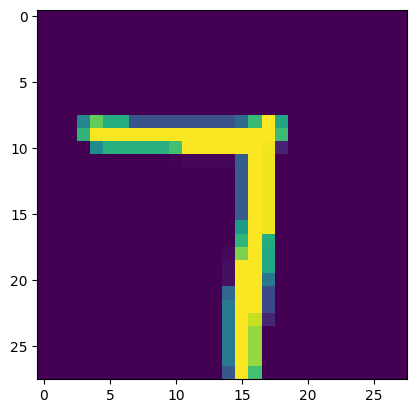

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(inputDict['pixel_values'][0][0])

(tensor(1.), tensor(-1.), tensor(-0.8255))

In [ ]:
import matplotlib.pyplot as plt

x[0].shape

plt.imshow(x[2].transpose(2,0))

In [ ]:
y

tensor([1, 1, 0])

In [ ]:
# pip install --upgrade calflops
!pip install deepspeed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 49.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 35.3 MB/s eta 0:00:00
  Created wheel for deepspeed: filename=deepspeed-0.16.5-py3-none-any.whl size=1580586 sha256=3883d1fa75d9ed88f5ffb38f717f3a02c8fd1288e08e7dc762641affff9eeb24
  Stored in directory: /root/.cache/pip/wheels/52/cc/7a/2a649465930859b5b227a30f75d9d19895f1d52f0b071a7486
Successfully built deepspeed


In [ ]:
gBatchSize = 4 #planning to implement more batch sizes
gDevice = 'cpu'
imageDim = 28

iConf = Configs #vision configs
iConf.embeddingChannels = 512
iConf.batchSize = gBatchSize
iConf.patchSize = 1
iConf.numLayers = 2
iConf.device = gDevice

tConf = TextConfigs
tConf.batchSize = gBatchSize
tConf.vocabSize = tokenizer.vocab_size + 1
tConf.visionEmbeddingChannels = iConf.embeddingChannels #this is so we just need to pass one config to the multiModalProjector
tConf.textEmbeddingChannels = 128
tConf.maxSeqLength = 32
tConf.numLayers = 1
tConf.device = gDevice

model1 = MultiModalPipeline(tConf, iConf, paliConfig, tokenizer).to(device=gDevice)

In [ ]:
from calflops import calculate_flops



flops, macs, params = calculate_flops(model=model1,
                                      input_shape=(3,3,28,28),
                                      output_as_string=True,
                                      output_precision=4)

flops, macs, params

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

In [ ]:
a = torch.tensor([2,2,3])
torch.cumprod(a, 0)[-1].item()

12

In [ ]:
t = 0
for p in model1.named_parameters():
  print(p[0], p[1].shape)
  eq = ''
  m = 1
  i =0

  for n in p[1].shape:
    eq += str(n) + ' x '
    m *= n
    i += 1
    t += m

  print(eq[:-3] + ' = ' + str(m) + ' total parameters for ' + p[0] if i > 1 else eq[:-3] + ' total parameters for ' + p[0])
  print()
print('================== total =============== {}'.format(t))

embed.weight torch.Size([257153, 128])
257153 x 128 = 32915584 total parameters for embed.weight

imageComponent.embed.patchConv.weight torch.Size([512, 3, 1, 1])
512 x 3 x 1 x 1 = 1536 total parameters for imageComponent.embed.patchConv.weight

imageComponent.embed.patchConv.bias torch.Size([512])
512 total parameters for imageComponent.embed.patchConv.bias

imageComponent.embed.positionEmbeddings.weight torch.Size([784, 512])
784 x 512 = 401408 total parameters for imageComponent.embed.positionEmbeddings.weight

imageComponent.layers.0.norm1.weight torch.Size([512])
512 total parameters for imageComponent.layers.0.norm1.weight

imageComponent.layers.0.norm1.bias torch.Size([512])
512 total parameters for imageComponent.layers.0.norm1.bias

imageComponent.layers.0.att.wq.weight torch.Size([512, 512])
512 x 512 = 262144 total parameters for imageComponent.layers.0.att.wq.weight

imageComponent.layers.0.att.wq.bias torch.Size([512])
512 total parameters for imageComponent.layers.0.att.w

In [ ]:
tokenizer.decode(torch.argmax(predictions, dim=1)), str(y.item())

('The digit is tensor([])])', '0')

In [ ]:
labels = torch.tensor(tokenizer.encode("The digit is " + str(y)), dtype = torch.long)
pred = F.softmax(logits[:,-labels.shape[0]:,:], dim = -1).reshape(logits.shape[0] * labels.shape[0], logits.shape[2])
labels = labels.tile((2))
F.cross_entropy(pred, labels)

In [ ]:
# labels = torch.tensor(tokenizer.encode("The digit is " + str(y)), dtype = torch.int)
# labels = labels.tile((2))

# labels.shape, pred.shape, logits.shape[0] * labels.shape[0]
# logits[:,-labels.shape[1]:,:].shape
pred.dtype

In [ ]:
labels

tensor([[   651,  22926,    603,  24614,   5917, 235324, 235269, 235248, 235310,
           3013],
        [   651,  22926,    603,  24614,   5917, 235324, 235269, 235248, 235310,
           3013]], dtype=torch.int32)

In [ ]:
F.softmax(logits, dim = -1).shape

torch.Size([2, 791, 257153])

In [ ]:
logits.shape

torch.Size([2, 791, 257153])

In [ ]:
x.shape, inputDict['input_ids'].shape

(torch.Size([2, 1, 28, 28]), torch.Size([1, 790]))

In [ ]:
tokenizer.decode(inputDict['input_ids'][0], skip_special_tokens=True), tokenizer.decode(torch.argmax(logits)), logits.shape
#F.softmax(logits[0,0], dim = -1)

('The number is \n', ' Mapper', torch.Size([1, 1, 257153]))

In [ ]:
logits.shape

torch.Size([1, 1, 257153])

In [ ]:
inputDict['input_ids'][0,:3]

tensor([257152, 257152, 257152])

In [ ]:
# inputDict['attention_mask'].cumsum(-1)[:,-1].unsqueeze(0).shape[0]
# (inputDict['attention_mask'].cumsum(-1)).masked_fill_((inputDict['attention_mask'] == 0), 1)

In [ ]:
def makeLabels(s, tokenizer, imgSeqLength):
      # Prepend a `self.image_seq_length` number of image tokens to the prompt
      input_strings = [
          add_image_tokens_to_prompt(
              prefix_prompt=prompt,
              bos_token=tokenizer.bos_token,
              image_seq_len=imgSeqLength,
              image_token='<image>',
          )
          for prompt in s
      ]

      # Returns the input_ids and attention_mask as PyTorch tensors
      inputs = tokenizer(
          input_strings,
          return_tensors="pt",
          padding = "longest",
          truncation=True,
      )

      return inputs

In [ ]:
makeLabels(["number 5"], tokenizer, 28*28)['input_ids'].transpose(1,0)[:,0].shape

torch.Size([789])

In [ ]:
makeLabels(["number 5"], tokenizer, 28*28)['input_ids']#,makeLabels(["The number is "], tokenizer, 28*28)


RuntimeError: "log_softmax_lastdim_kernel_impl" not implemented for 'Long'

60000

RuntimeError: shape '[1, 196, 32]' is invalid for input of size 25088

In [ ]:
4 * 196 * 32

25088

In [ ]:
e = nn.Embedding(tokenizer.vocab_size + 1, 4)
e(inputDict['input_ids'])

tensor([[[-0.1572, -0.3590,  1.3985,  1.1816],
         [-0.1572, -0.3590,  1.3985,  1.1816],
         [-0.1572, -0.3590,  1.3985,  1.1816],
         ...,
         [-1.4358, -0.9771,  0.8117, -1.6045],
         [ 1.1771, -0.1869,  1.1198,  0.2791],
         [-0.8930,  1.4164,  0.5055,  0.3972]]], grad_fn=<EmbeddingBackward0>)

In [ ]:
print(inputDict['input_ids'].shape)

torch.Size([1, 790])


In [ ]:
# tokenizer.vocab_size

In [ ]:
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from PIL import Image
import requests
import torch

model_id = "google/paligemma-3b-mix-224"
device = "cpu"#"cuda:0"
dtype = torch.bfloat16

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
# image = Image.open(requests.get(url, stream=True).raw)
image = torchvision.transforms.functional.to_pil_image(x[0].tile((3,1, 1)))

model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=dtype,
    device_map=device,
    revision="bfloat16",
).eval()
processor = AutoProcessor.from_pretrained(model_id)

# Instruct the model to create a caption in Spanish
prompt = "What number is this?"
model_inputs = processor(text=prompt, images=image, return_tensors="pt").to(model.device)
input_len = model_inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**model_inputs, max_new_tokens=100, do_sample=False)
    generation = generation[0][input_len:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    print('\n Answer: \n', decoded)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.



 Answer: 
 0


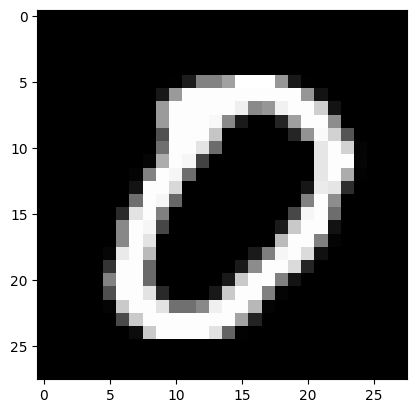

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)

In [ ]:
model.state_dict()

OrderedDict([('vision_tower.vision_model.embeddings.patch_embedding.weight',
              tensor([[[[-1.8066e-02, -2.2949e-02, -2.4658e-02,  ..., -3.4027e-03,
                          3.2227e-02,  5.4443e-02],
                        [-8.7891e-03, -1.1841e-02, -1.5991e-02,  ...,  6.3171e-03,
                          2.3682e-02,  3.6133e-02],
                        [ 1.3275e-03,  3.0823e-03, -1.5381e-02,  ...,  1.0925e-02,
                          1.2665e-03,  1.3550e-02],
                        ...,
                        [-8.9722e-03,  3.6133e-02,  3.2471e-02,  ..., -1.7090e-02,
                         -2.4414e-02, -1.6479e-02],
                        [-1.3184e-02,  3.4912e-02,  4.3945e-02,  ..., -2.9053e-02,
                         -3.5645e-02, -3.1738e-02],
                        [-4.0283e-02,  4.7363e-02,  6.1768e-02,  ..., -3.0396e-02,
                         -3.2471e-02, -3.0518e-02]],
              
                       [[-2.4536e-02, -3.0518e-02, -3.5400e-02,  ...

In [ ]:
d

<bound method PaliGemmaProcessor.__call__ of <__main__.PaliGemmaProcessor object at 0x7f868387ea10>>

In [ ]:
# MODEL_PATH="$HOME/projects/paligemma-weights/paligemma-3b-pt-224"
# PROMPT="this building is "
# IMAGE_FILE_PATH="test_images/pic1.jpeg"
# MAX_TOKENS_TO_GENERATE=100
# TEMPERATURE=0.8
# TOP_P=0.9
# DO_SAMPLE="False"
# ONLY_CPU="False"

# python inference.py \
#     --model_path "$MODEL_PATH" \
#     --prompt "$PROMPT" \
#     --image_file_path "$IMAGE_FILE_PATH" \
#     --max_tokens_to_generate $MAX_TOKENS_TO_GENERATE \
#     --temperature $TEMPERATURE \
#     --top_p $TOP_P \
#     --do_sample $DO_SAMPLE \
#     --only_cpu $ONLY_CPU \



torch.Size([196])

In [ ]:
# import os

# os.mkdir('testImages')

'/content'

In [ ]:
import os
# os.getcwd()
os.listdir('testImages')
img = np.array(Image.open('testImages/garden.jpg'))
img.shape

(1200, 1800, 3)

100%|██████████| 9.91M/9.91M [00:00<00:00, 40.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.17MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.64MB/s]


NameError: name 'VisionComponent' is not defined